In [1]:
import numpy as np
import torch
from itertools import product
import matplotlib.pyplot as plt
from dataclasses import dataclass
from matplotlib.animation import FuncAnimation
import random
from enviroments import env_red, P_j, P_j_dist, env_red_p2p, env_red_toy1, env_hubs0
import pickle
from algorithms.Action_Gen import Action_generation
from algorithms.RDQL import action_space_generation, ini_action_list, caculate_op_cost,update_action_space
from algorithms.DQL import DQL_algorithm, select_action
from algorithms.QL_LowRank import select_action as select_action_LR


NUMERO_DE_NUCLEOS = 16

torch.set_num_threads(NUMERO_DE_NUCLEOS)


In [16]:
env = env_red_toy1("MNL",400)

In [19]:
env.action_space[0]

(0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

In [21]:
def integer_to_binary_tuple(integer, word_size):
    # Obtener la representación binaria del número entero sin el prefijo '0b'
    binary_str = bin(integer)[2:]

    # Asegurarse de que la cadena binaria tenga el tamaño deseado llenando con ceros a la izquierda si es necesario
    binary_str = binary_str.zfill(word_size)

    # Crear una tupla con cada bit del número binario
    binary_tuple = tuple(int(bit) for bit in binary_str)

    return binary_tuple

# Ejemplo de uso:
numero = 10
tamaño_palabra = 8
binario = integer_to_binary_tuple(numero, tamaño_palabra)
print(f"El número {numero} en binario con tamaño de palabra {tamaño_palabra} es: {binario}")



El número 10 en binario con tamaño de palabra 8 es: (0, 0, 0, 0, 1, 0, 1, 0)


In [5]:
A_ij = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
])

A_ij = np.concatenate((A_ij, A_ij), axis=1)

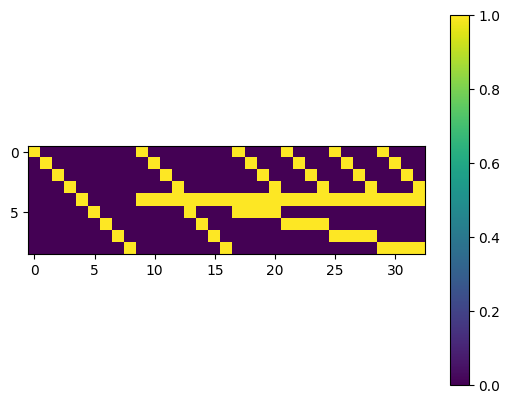

In [8]:
plt.imshow(A_ij[:,:33])
plt.colorbar()

In [2]:
carpeta = "results/Exp5"
Demand_Model = "Exp"
Red_name = "red1"

In [3]:
T = 400
env = env_red_toy1(Demand_Model,T)
# DQL
Qfun_model = "NN"
with open(carpeta +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    data = pickle.load(f)

qnet_exp = data["qfun_exp"]

#LRQL
Qfun_model = "LR"
with open(carpeta +"/" + Demand_Model + "_" + Qfun_model +"_" + Red_name +".pickle", 'rb') as f:
    data = pickle.load(f)
    
qtensor_exp = data["qfun_exp"]

In [4]:
num_sim = 1000
max_steps = 400
Qfun = qtensor_exp[0]
model = "LR"

Rs = []
r_t= []
s_t = []
a_t = []

for episode in range(num_sim):
    s, _ = env.set_initial(s = [0]*env.I)
    R = 0
    for step in range(max_steps):

        if model == "NN":
            a = select_action(Qfun, s, 0, len(env.action_space))
        if model == "LR":
            a = select_action_LR(Qfun, s, 0, len(env.action_space))

        s_prime, r, done, _, _ = env.step(a)
            
        r_t.append(r)
        s_t.append(s)
        a_t.append(a) 

        R += r

        if done:
            break
                
        s = s_prime
    Rs.append(R)

IndexError: list index out of range

In [9]:
def compare_Qfun(env, Qfun1, Qfun2, model1, model2):

    s_vecors = [range(0,c) for c in env.C]
    s_vecors.append(range(env.T-1))
    dif = 0  # Inicializar el máximo como negativo infinito
    
    for s_i in (product(*s_vecors)):

        s = torch.tensor(s_i, dtype=torch.double)

        if model1 == "NN":
            val1 = torch.max(Qfun1(s)).item()
        elif model1 == "LR":
            val1 = torch.max(Qfun1(torch.tensor(s_i, dtype=torch.long).view(1, -1))).item()

        if model2 == "NN":
            val2 = torch.max(Qfun2(s)).item()
        elif model2 == "LR":
            val2 = torch.max(Qfun2(torch.tensor(s_i, dtype=torch.long).view(1, -1))).item()

        dif += abs(val1-val2)

    return dif

In [28]:
def compare_Qfun_exp(env,Qfun_list, model,name):
    data = np.zeros((len(Qfun_list), len(Qfun_list)))
    for q1 in range(len(Qfun_list)):
        for q2 in range(q1+1,len(Qfun_list)):
            diff = compare_Qfun(env, Qfun_list[q1], Qfun_list[q2], model, model)
            data[q1, q2] = diff
            data[q2, q1] = diff
    plt.imshow(np.array(data))
    plt.title("Diferencia en las funciones de valor")
    plt.xlabel("Exp1")
    plt.ylabel("Exp2")
    plt.colorbar()
    plt.savefig(name)

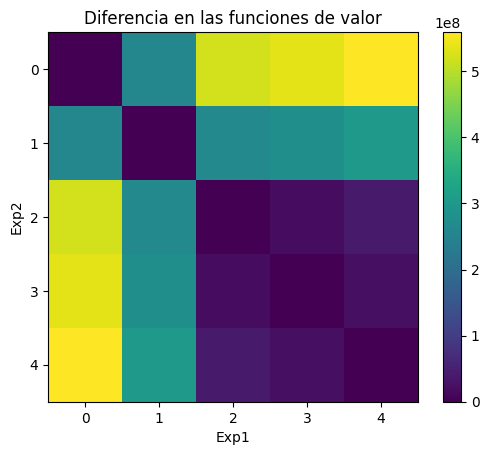

In [29]:
compare_Qfun_exp(env,qnet_exp,"NN","Prueba")

In [26]:
print(diff_matrix)

[[0.00000000e+00 2.59065887e+08 5.20095892e+08 5.37035516e+08
  5.59091145e+08]
 [2.59065887e+08 0.00000000e+00 2.62083752e+08 2.79219465e+08
  3.01322499e+08]
 [5.20095892e+08 2.62083752e+08 0.00000000e+00 1.80220941e+07
  3.98159048e+07]
 [5.37035516e+08 2.79219465e+08 1.80220941e+07 0.00000000e+00
  2.27477822e+07]
 [5.59091145e+08 3.01322499e+08 3.98159048e+07 2.27477822e+07
  0.00000000e+00]]


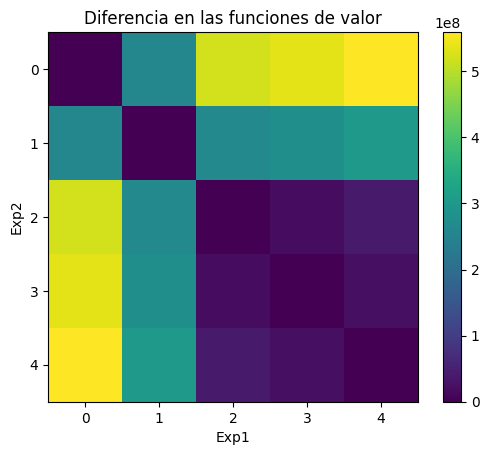

In [27]:
plt.imshow(np.array(diff_matrix))
plt.title("Diferencia en las funciones de valor")
plt.xlabel("Exp1")
plt.ylabel("Exp2")
plt.colorbar()


In [28]:
# DQL
env = env_red_toy()

nS = env.I + 1
nA = len(env.action_space)
nH = 128

qnet = torch.nn.Sequential(
    torch.nn.Linear(nS, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nH),
    torch.nn.ReLU(),
    torch.nn.Linear(nH, nA)
).double()

qnet.load_state_dict(torch.load("results/qnet_toy.pth"))

<All keys matched successfully>

In [29]:
def get_toy_slide(qnet, t, states_map,C_1,C_2):
    t = 0
    data = np.zeros((len(C_1),len(C_2)))
    for (x1,x2) in (list(product(C_1,C_2))):
        idx = states_map[(x1,x2,t)]
        s = torch.tensor([x1,x2, t], dtype=torch.double)
        data[x1,x2] = torch.max(qnet(s))
    return data

Text(0, 0.5, 'Asientos vendidos, x1')

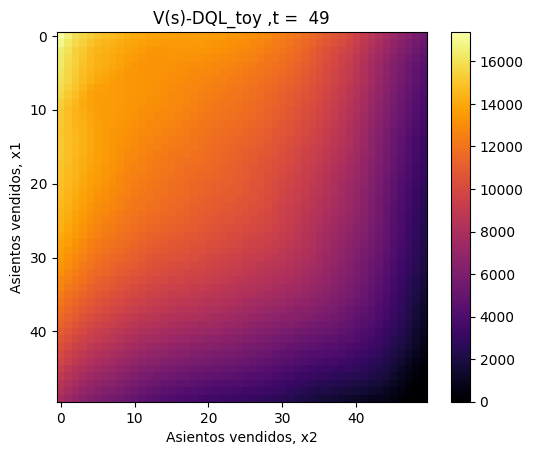

In [30]:
C_1 = range(0,env.C[0])
C_2 = range(0,env.C[1])
T_RANGE = range(0,env.T)

states_map = {}

for idx, (x1,x2, t) in enumerate(list(product(C_1,C_2,T_RANGE))):
            states_map[(x1,x2, t)] = idx

vmax = torch.max(qnet(torch.tensor([0,0, 0], dtype=torch.double)))

data = get_toy_slide(qnet, t, states_map,C_1,C_2)

plt.imshow(data, cmap='inferno', interpolation='nearest',vmin=0, vmax=vmax)
    
plt.colorbar()  # Agregar barra de colores para referencia
plt.title(f'V(s)-DQL_toy ,t =  {t}')
plt.xlabel('Asientos vendidos, x2')
plt.ylabel('Asientos vendidos, x1')


In [31]:
def get_tensor_from_net(qnet,env):
    dimensiones = [c for c in env.C]
    dimensiones.append(env.T)
    #dimensiones.append(len(env.action_space))

    tensor = torch.zeros(dimensiones)
    # Genera las combinaciones de índices usando itertools.product
    combinaciones = product(*(range(valor) for valor in dimensiones))

    # Itera sobre las combinaciones
    for combinacion in combinaciones:
        #tensor[combinacion] = qnet(torch.tensor(combinacion[:-1],dtype=torch.double))[combinacion[-1]]
        tensor[combinacion] = torch.max(qnet(torch.tensor(combinacion,dtype=torch.double)))
    return tensor

tensor = get_tensor_from_net(qnet,env)



tf.Tensor(3, shape=(), dtype=int32)


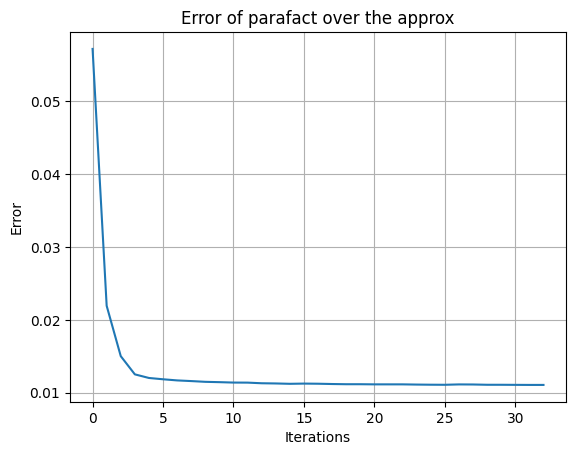

In [55]:
rank = tf.rank(tensor.detach().numpy())
print(rank)

k = 5
# Realizar la descomposición PARAFAC
CPTensor, err = tl.decomposition.parafac(tensor.detach().numpy(),rank=k, return_errors = True)

factors = []
for factor in CPTensor.factors:
    factors.append(torch.tensor(factor))

plt.plot(err)
plt.grid()
plt.title("Error of parafact over the approx")
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.show()


In [56]:
def tensor_forward(factors,k,indices):
    bsz = indices.shape[0]
    prod = torch.ones(bsz, k, dtype=torch.double)
    for i in range(indices.shape[1]):
        idx = indices[:, i]
        factor = factors[i]
        prod *= factor[idx, :]
    if indices.shape[1] < len(factors):
        return torch.matmul(prod, factors[-1].T)
    return torch.sum(prod, dim=-1)




MovieWriter imagemagick unavailable; using Pillow instead.


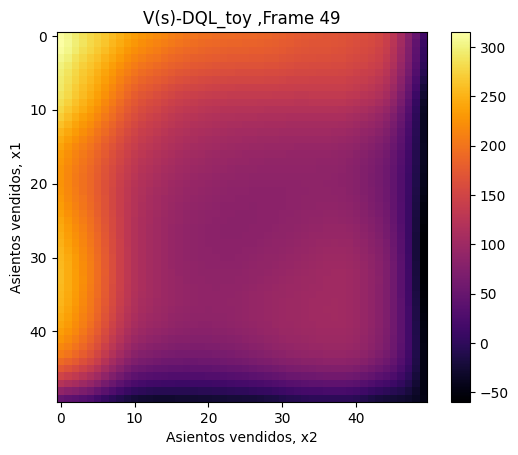

In [57]:
# Función para generar datos de la imagen
def generate_data(frame):
    t = frame
    data = np.zeros((len(C_1),len(C_2)))
    for (x1,x2) in (list(product(C_1,C_2))):
        s = torch.tensor([x1,x2, t], dtype=torch.long).view(1, -1)
        data[x1,x2] =tensor_forward(factors,k,s)
    return data

# Función para la animación
def animate(frame):
    plt.clf()  # Limpiar el gráfico en cada frame
    data = generate_data(frame)
    plt.imshow(data, cmap='inferno', interpolation='nearest')
    
    plt.colorbar()  # Agregar barra de colores para referencia
    plt.title(f'V(s)-DQL_toy ,Frame {frame}')
    plt.xlabel('Asientos vendidos, x2')
    plt.ylabel('Asientos vendidos, x1')
    

# Crear la figura
fig, ax = plt.subplots()

# Crear la animación
animation = FuncAnimation(fig, animate, frames=50, interval=200)

# Guardar la animación en un archivo GIF
animation.save('DQL-to_tensor-reconstruida.gif', writer='imagemagick', fps=5)

# Mostrar el gráfico
plt.show()